
# ========================================
# 3. CHUẨN BỊ DỮ LIỆU CHO MARKET BASKET ANALYSIS
# ========================================

## PHẦN 1: CHUẨN BỊ DỮ LIỆU

###  3.1 Tạo transaction dataset


In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import os
from mlxtend.frequent_patterns import apriori, fpgrowth, association_rules
from mlxtend.preprocessing import TransactionEncoder
import networkx as nx
from itertools import combinations
import time

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("tab10")

In [29]:
df = pd.read_csv('../data/processed/cleaned_data.csv')
print(f"\n Đã load data: {df.shape[0]:,} transactions")


 Đã load data: 99,457 transactions


In [40]:
print("\n[1] TẠO TRANSACTION DATASET:")
print("  Mỗi transaction (invoice) chứa list các categories")

# Group by invoice_no để lấy danh sách categories
if all(col in df.columns for col in ['invoice_no', 'category']):
    transactions = df.groupby('invoice_no')['category'].apply(list).values.tolist()

    print(f"\n   Số transactions: {len(transactions):,}")
    print(f"   Trung bình items/transaction: {np.mean([len(t) for t in transactions]):.2f}")
    print(f"   Max items/transaction: {max([len(t) for t in transactions])}")
    print(f"   Min items/transaction: {min([len(t) for t in transactions])}")

    # Hiển thị ví dụ transactions
    print("\n  Ví dụ 5 transactions đầu tiên:")
    for i, trans in enumerate(transactions[:5], 1):
        print(f"    {i}. {trans}")


[1] TẠO TRANSACTION DATASET:
  Mỗi transaction (invoice) chứa list các categories

   Số transactions: 99,457
   Trung bình items/transaction: 1.00
   Max items/transaction: 1
   Min items/transaction: 1

  Ví dụ 5 transactions đầu tiên:
    1. ['Clothing']
    2. ['Cosmetics']
    3. ['Clothing']
    4. ['Books']
    5. ['Technology']


###  3.2 Phân tích items frequency


[2] PHÂN TÍCH ITEM FREQUENCY:

  Số categories duy nhất: 8

  Top 10 categories phổ biến nhất:
Clothing           34487
Cosmetics          15097
Food & Beverage    14776
Toys               10087
Shoes              10034
Souvenir            4999
Technology          4996
Books               4981
Name: count, dtype: int64


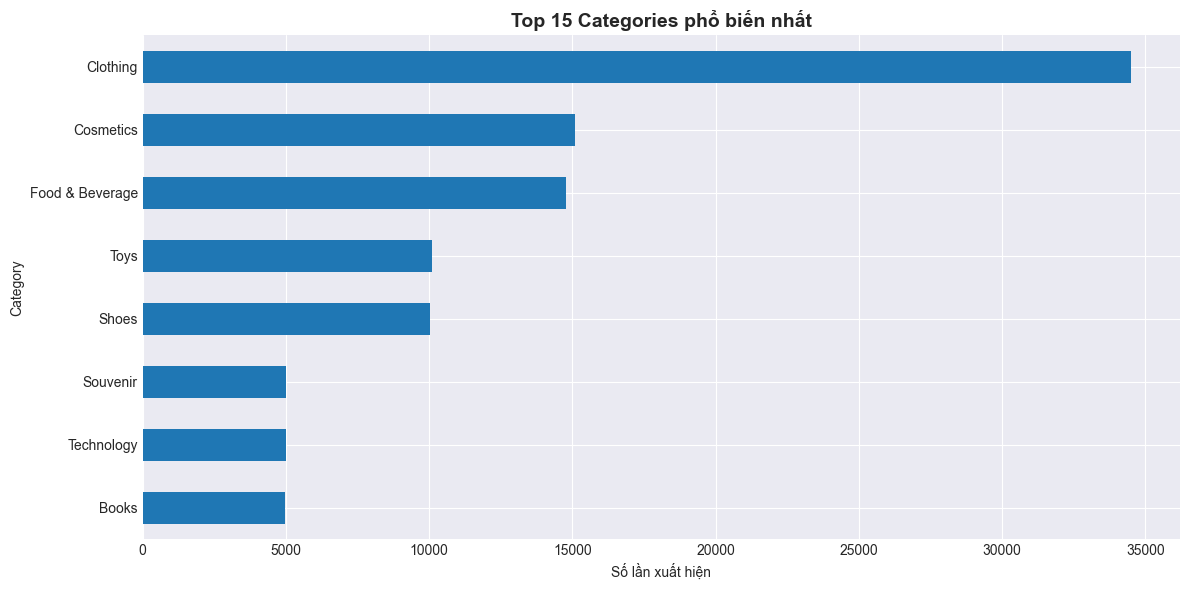


 Đã lưu: figures/01_item_frequency.png


In [41]:
print("\n[2] PHÂN TÍCH ITEM FREQUENCY:")

# Flatten all items
all_items = [item for sublist in transactions for item in sublist]
item_counts = pd.Series(all_items).value_counts()

print(f"\n  Số categories duy nhất: {len(item_counts)}")
print("\n  Top 10 categories phổ biến nhất:")
print(item_counts.head(10))

# Visualize item frequency
plt.figure(figsize=(12, 6))
item_counts.head(15).plot(kind='barh')
plt.title('Top 15 Categories phổ biến nhất', fontsize=14, fontweight='bold')
plt.xlabel('Số lần xuất hiện')
plt.ylabel('Category')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('figures/01_item_frequency.png', dpi=300, bbox_inches='tight')
plt.show()
print("\n Đã lưu: figures/01_item_frequency.png")

###  3.3 Chuyển đổi sang One-Hot Encoding

In [42]:
print("\n[3] CHUYỂN ĐỔI SANG ONE-HOT ENCODING:")

te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df_encoded = pd.DataFrame(te_ary, columns=te.columns_)

print(f"   Shape: {df_encoded.shape}")
print(f"   Sparsity: {(1 - df_encoded.sum().sum() / (df_encoded.shape[0] * df_encoded.shape[1]))*100:.2f}%")


[3] CHUYỂN ĐỔI SANG ONE-HOT ENCODING:
   Shape: (99457, 8)
   Sparsity: 87.50%


# ========================================
# 4. APRIORI ALGORITHM
# ========================================

PHẦN 2: APRIORI ALGORITHM

###  4.1 Thử nghiệm với các giá trị min_support khác nhau

In [43]:
print("\n[1] THỬ NGHIỆM VỚI CÁC MIN_SUPPORT:")

support_values = [0.01, 0.02, 0.03, 0.05]
apriori_results = {}

for min_sup in support_values:
    start_time = time.time()
    frequent_itemsets = apriori(df_encoded, min_support=min_sup, use_colnames=True)
    exec_time = time.time() - start_time

    apriori_results[min_sup] = {
        'itemsets': frequent_itemsets,
        'count': len(frequent_itemsets),
        'time': exec_time
    }

    print(f"\n  min_support={min_sup}:")
    print(f"    - Số frequent itemsets: {len(frequent_itemsets)}")
    print(f"    - Thời gian: {exec_time:.2f}s")


[1] THỬ NGHIỆM VỚI CÁC MIN_SUPPORT:

  min_support=0.01:
    - Số frequent itemsets: 8
    - Thời gian: 0.01s

  min_support=0.02:
    - Số frequent itemsets: 8
    - Thời gian: 0.01s

  min_support=0.03:
    - Số frequent itemsets: 8
    - Thời gian: 0.01s

  min_support=0.05:
    - Số frequent itemsets: 8
    - Thời gian: 0.01s


### 4.2 Chọn min_support tối ưu

In [ ]:
optimal_min_support = 0.02  # Có thể điều chỉnh
print(f"\n[2] SỬ DỤNG min_support={optimal_min_support}:")

frequent_itemsets_apriori = apriori_results[optimal_min_support]['itemsets']
print(f"   Số frequent itemsets: {len(frequent_itemsets_apriori)}")

# Phân tích theo itemset size
print("\n  Phân bố theo kích thước itemset:")
itemset_sizes = frequent_itemsets_apriori['itemsets'].apply(len)
print(itemset_sizes.value_counts().sort_index())

# 4.3 Generate Association Rules
print("\n[3] GENERATE ASSOCIATION RULES:")

# Thử nghiệm với các metrics và thresholds
metrics_configs = [
    {'metric': 'confidence', 'min_threshold': 0.3},
    {'metric': 'confidence', 'min_threshold': 0.5},
    {'metric': 'lift', 'min_threshold': 1.2}
]

rules_comparison = {}

for config in metrics_configs:
    try:
        rules = association_rules(frequent_itemsets_apriori,
                                 metric=config['metric'],
                                 min_threshold=config['min_threshold'])
        rules_comparison[f"{config['metric']}_{config['min_threshold']}"] = rules
        print(f"\n  {config['metric']} >= {config['min_threshold']}: {len(rules)} rules")
    except:
        print(f"\n  {config['metric']} >= {config['min_threshold']}: 0 rules")

# Chọn rules với confidence >= 0.3
rules_apriori = rules_comparison.get('confidence_0.3', pd.DataFrame())

if len(rules_apriori) > 0:
    print(f"\n[4] TOP 10 RULES (sorted by lift):")
    rules_sorted = rules_apriori.sort_values('lift', ascending=False).head(10)

    for idx, row in rules_sorted.iterrows():
        print(f"\n  Rule {idx + 1}:")
        print(f"    {list(row['antecedents'])} => {list(row['consequents'])}")
        print(f"    - Support: {row['support']:.4f}")
        print(f"    - Confidence: {row['confidence']:.4f}")
        print(f"    - Lift: {row['lift']:.4f}")


[2] SỬ DỤNG min_support=0.02:
  ✓ Số frequent itemsets: 8

  Phân bố theo kích thước itemset:
itemsets
1    8
Name: count, dtype: int64

[3] GENERATE ASSOCIATION RULES:

  confidence >= 0.3: 0 rules

  confidence >= 0.5: 0 rules

  lift >= 1.2: 0 rules


In [35]:
from mlxtend.frequent_patterns import association_rules

print("\n[GENERATE ASSOCIATION RULES]")

rules_apriori = association_rules(
    frequent_itemsets_apriori,
    metric="confidence",
    min_threshold=0.05   
)

print("Total rules found:", len(rules_apriori))

# Nếu vẫn không có (hiếm)
if rules_apriori.empty:
    rules_apriori = pd.DataFrame(
        columns=['antecedents', 'consequents', 'support', 'confidence', 'lift']
    )



[GENERATE ASSOCIATION RULES]
Total rules found: 0


# ========================================
# 5. FP-GROWTH ALGORITHM
# ========================================

PHẦN 3: FP-GROWTH ALGORITHM

In [45]:
print("PHẦN 3: FP-GROWTH ALGORITHM")
print("="*70)

print("\n[1] RUN FP-GROWTH:")

start_time = time.time()
frequent_itemsets_fpgrowth = fpgrowth(df_encoded, min_support=optimal_min_support, use_colnames=True)
fpgrowth_time = time.time() - start_time

print(f"   Số frequent itemsets: {len(frequent_itemsets_fpgrowth)}")
print(f"   Thời gian: {fpgrowth_time:.2f}s")

# Generate rules from FP-Growth
print("\n[2] GENERATE RULES FROM FP-GROWTH:")

try:
    rules_fpgrowth = association_rules(frequent_itemsets_fpgrowth,
                                       metric='confidence',
                                       min_threshold=0.3)
    print(f"   Số rules: {len(rules_fpgrowth)}")

    print(f"\n[3] TOP 10 RULES (sorted by lift):")
    rules_fpg_sorted = rules_fpgrowth.sort_values('lift', ascending=False).head(10)

    for idx, row in rules_fpg_sorted.iterrows():
        print(f"\n  Rule {idx + 1}:")
        print(f"    {list(row['antecedents'])} => {list(row['consequents'])}")
        print(f"    - Support: {row['support']:.4f}")
        print(f"    - Confidence: {row['confidence']:.4f}")
        print(f"    - Lift: {row['lift']:.4f}")
except:
    rules_fpgrowth = pd.DataFrame()
    print("   Không tìm thấy rules!")

PHẦN 3: FP-GROWTH ALGORITHM

[1] RUN FP-GROWTH:
   Số frequent itemsets: 8
   Thời gian: 0.37s

[2] GENERATE RULES FROM FP-GROWTH:
   Số rules: 0

[3] TOP 10 RULES (sorted by lift):


# ========================================
# 6. COMPARISON: APRIORI VS FP-GROWTH
# ========================================

### PHẦN 4: SO SÁNH APRIORI VS FP-GROWTH

PHẦN 4: SO SÁNH APRIORI VS FP-GROWTH

Algorithm  Frequent Itemsets  Association Rules  Execution Time (s)
  Apriori                  8                  0            0.009725
FP-Growth                  8                  0            0.366855


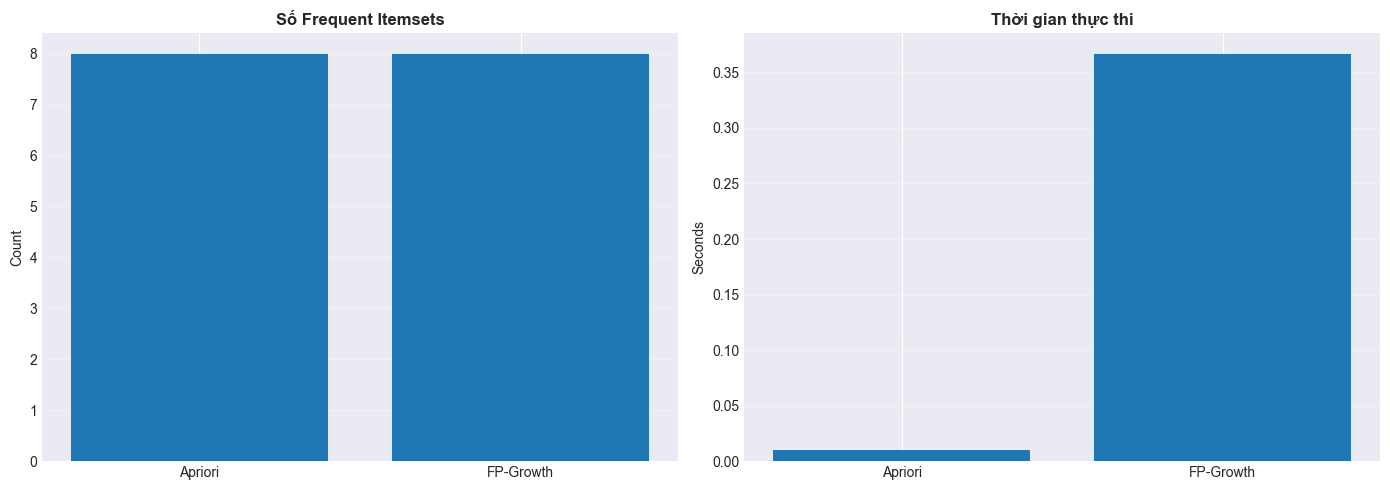


 Đã lưu: figures/02_algorithm_comparison.png


In [46]:
print("PHẦN 4: SO SÁNH APRIORI VS FP-GROWTH")
print("="*70)

comparison_df = pd.DataFrame({
    'Algorithm': ['Apriori', 'FP-Growth'],
    'Frequent Itemsets': [len(frequent_itemsets_apriori), len(frequent_itemsets_fpgrowth)],
    'Association Rules': [len(rules_apriori), len(rules_fpgrowth)],
    'Execution Time (s)': [apriori_results[optimal_min_support]['time'], fpgrowth_time]
})

print("\n" + comparison_df.to_string(index=False))

# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Frequent itemsets comparison
axes[0].bar(comparison_df['Algorithm'], comparison_df['Frequent Itemsets'])
axes[0].set_title('Số Frequent Itemsets', fontweight='bold')
axes[0].set_ylabel('Count')
axes[0].grid(axis='y', alpha=0.3)

# Execution time comparison
axes[1].bar(comparison_df['Algorithm'], comparison_df['Execution Time (s)'])
axes[1].set_title('Thời gian thực thi', fontweight='bold')
axes[1].set_ylabel('Seconds')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('figures/02_algorithm_comparison.png', dpi=300, bbox_inches='tight')
plt.show()
print("\n Đã lưu: figures/02_algorithm_comparison.png")

# ========================================
# 7. RULES VISUALIZATION
# ========================================

### PHẦN 5: TRỰC QUAN HÓA RULES

In [47]:
# Chọn rules để visualize (từ Apriori hoặc FP-Growth)
rules_viz = rules_apriori if len(rules_apriori) > 0 else rules_fpgrowth

if len(rules_viz) > 0:
    # 7.1 Support vs Confidence Scatter Plot
    print("\n[1] SUPPORT VS CONFIDENCE PLOT:")

    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(rules_viz['support'],
                         rules_viz['confidence'],
                         c=rules_viz['lift'],
                         cmap='viridis',
                         alpha=0.6,
                         s=100)
    plt.xlabel('Support', fontsize=12)
    plt.ylabel('Confidence', fontsize=12)
    plt.title('Association Rules: Support vs Confidence (colored by Lift)',
              fontsize=14, fontweight='bold')
    plt.colorbar(scatter, label='Lift')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('figures/03_support_confidence_plot.png', dpi=300, bbox_inches='tight')
    plt.show()
    print(" Đã lưu: figures/03_support_confidence_plot.png")


[2] RULES NETWORK GRAPH:


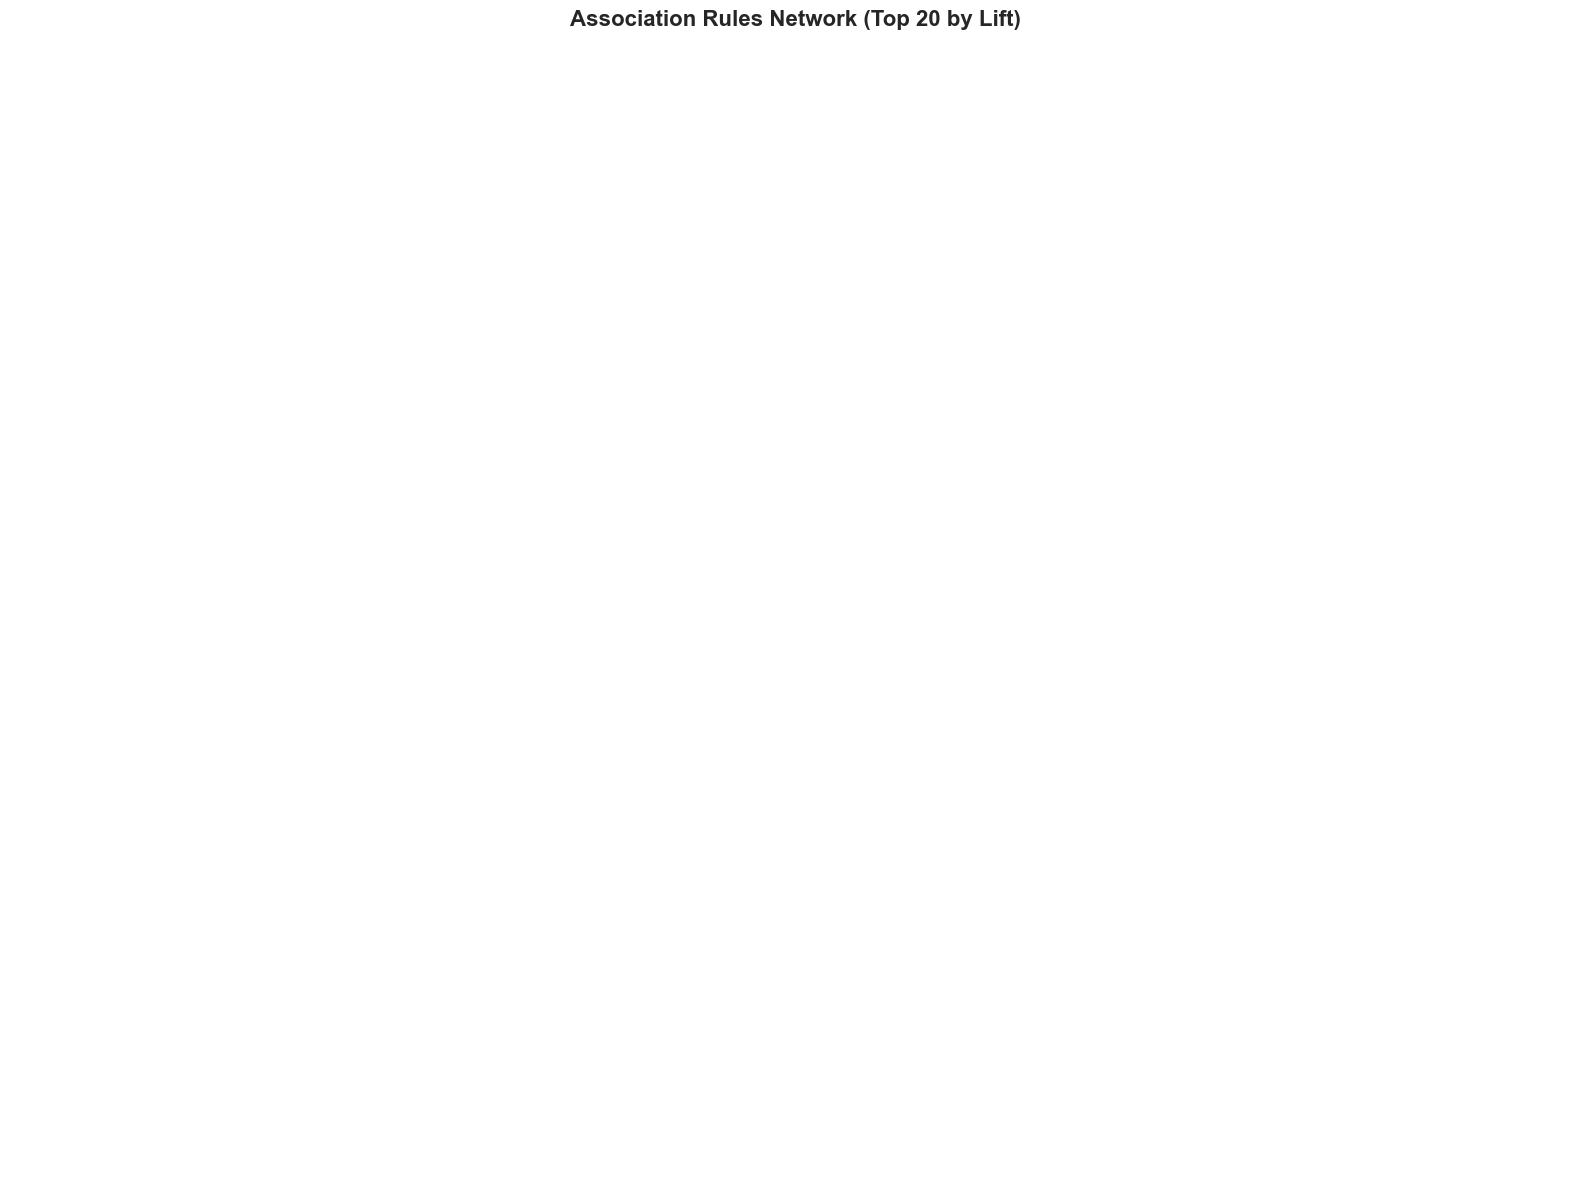

 Đã lưu: figures/04_rules_network.png


In [50]:
print("\n[2] RULES NETWORK GRAPH:")

    # Chọn top rules để visualize (tránh quá đông)
top_rules = rules_viz.sort_values('lift', ascending=False).head(20)

G = nx.DiGraph()

for idx, row in top_rules.iterrows():
        antecedents = list(row['antecedents'])
        consequents = list(row['consequents'])

        for ant in antecedents:
            for con in consequents:
                G.add_edge(ant, con, weight=row['lift'])
plt.figure(figsize=(16, 12))
pos = nx.spring_layout(G, k=0.5, iterations=50)

    # Draw nodes
nx.draw_networkx_nodes(G, pos, node_size=2000, node_color='lightblue',
                          alpha=0.9, edgecolors='black', linewidths=2)

    # Draw edges
edges = G.edges()
weights = [G[u][v]['weight'] for u, v in edges]
nx.draw_networkx_edges(G, pos, width=weights, alpha=0.6,
                          edge_color='gray', arrows=True,
                          arrowsize=20, arrowstyle='->')

    # Draw labels
nx.draw_networkx_labels(G, pos, font_size=8, font_weight='bold')

plt.title('Association Rules Network (Top 20 by Lift)',
              fontsize=16, fontweight='bold')
plt.axis('off')
plt.tight_layout()
plt.savefig('figures/04_rules_network.png', dpi=300, bbox_inches='tight')
plt.show()
print(" Đã lưu: figures/04_rules_network.png")

   


[3] LIFT DISTRIBUTION:


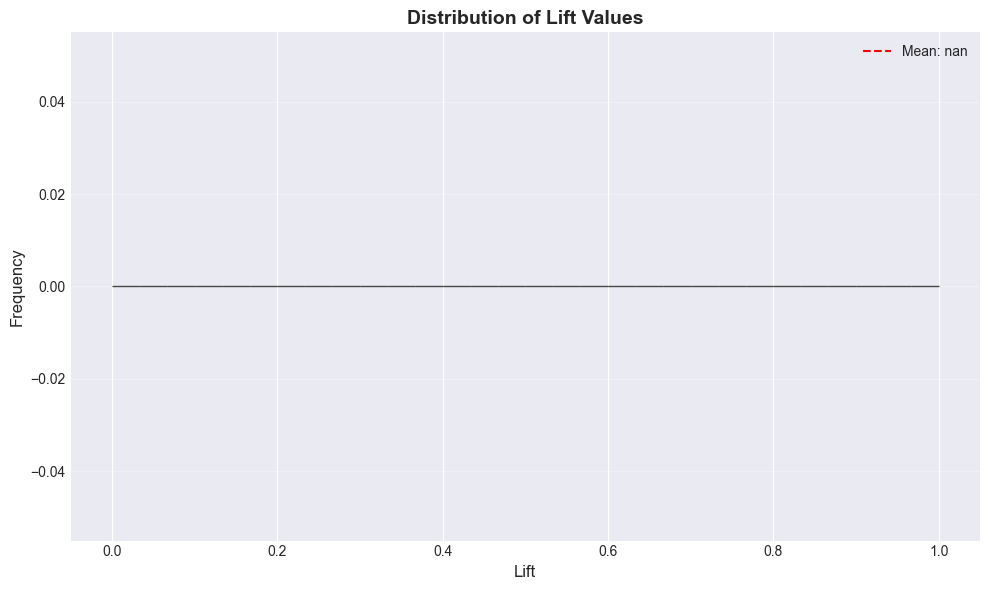

 Đã lưu: figures/05_lift_distribution.png


In [51]:
 # 7.3 Lift Distribution
print("\n[3] LIFT DISTRIBUTION:")

plt.figure(figsize=(10, 6))
plt.hist(rules_viz['lift'], bins=30, edgecolor='black', alpha=0.7)
plt.axvline(rules_viz['lift'].mean(), color='red', linestyle='--',
                label=f'Mean: {rules_viz["lift"].mean():.2f}')
plt.xlabel('Lift', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Lift Values', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('figures/05_lift_distribution.png', dpi=300, bbox_inches='tight')
plt.show()
print(" Đã lưu: figures/05_lift_distribution.png")


# ========================================
# 8. RULES ANALYSIS BY METRICS
# ========================================

### PHẦN 6: PHÂN TÍCH RULES THEO METRICS

In [52]:
if len(rules_viz) > 0:
    print("\n[1] RULES VỚI LIFT CAO NHẤT (>= 2.0):")
    high_lift = rules_viz[rules_viz['lift'] >= 2.0].sort_values('lift', ascending=False)
    print(f"  Số rules: {len(high_lift)}")

    if len(high_lift) > 0:
        print("\n  Top 5 rules:")
        for idx, row in high_lift.head(5).iterrows():
            print(f"\n    {list(row['antecedents'])} => {list(row['consequents'])}")
            print(f"    Lift: {row['lift']:.4f}, Confidence: {row['confidence']:.4f}")

    print("\n[2] RULES VỚI CONFIDENCE CAO NHẤT (>= 0.7):")
    high_conf = rules_viz[rules_viz['confidence'] >= 0.7].sort_values('confidence', ascending=False)
    print(f"  Số rules: {len(high_conf)}")

    if len(high_conf) > 0:
        print("\n  Top 5 rules:")
        for idx, row in high_conf.head(5).iterrows():
            print(f"\n    {list(row['antecedents'])} => {list(row['consequents'])}")
            print(f"    Confidence: {row['confidence']:.4f}, Lift: {row['lift']:.4f}")

    print("\n[3] RULES VỚI SUPPORT CAO NHẤT:")
    high_sup = rules_viz.sort_values('support', ascending=False).head(10)
    print("\n  Top 10 rules:")
    for idx, row in high_sup.iterrows():
        print(f"\n    {list(row['antecedents'])} => {list(row['consequents'])}")
        print(f"    Support: {row['support']:.4f}")

# ========================================
# 9. BUSINESS INSIGHTS
# ========================================

### PHẦN 7: BUSINESS INSIGHTS & RECOMMENDATIONS

In [53]:
if len(rules_viz) > 0:
    # Top product pairs
    print("\n[1] TOP PRODUCT COMBINATIONS (Lift >= 1.5):")

    actionable_rules = rules_viz[rules_viz['lift'] >= 1.5].sort_values('lift', ascending=False).head(10)

    insights = []
    for idx, row in actionable_rules.iterrows():
        ant = list(row['antecedents'])
        con = list(row['consequents'])

        insight = {
            'Rule': f"{ant} => {con}",
            'Lift': row['lift'],
            'Confidence': row['confidence'],
            'Support': row['support'],
            'Recommendation': f"Khách mua {ant[0]} thường mua {con[0]} (tỷ lệ {row['confidence']*100:.1f}%)"
        }
        insights.append(insight)

    insights_df = pd.DataFrame(insights)
    print("\n" + insights_df.to_string(index=False))

    # Save actionable insights
    insights_df.to_csv('actionable_insights.csv', index=False, encoding='utf-8')
    print("\n Đã lưu: actionable_insights.csv")

# ========================================
# 10. SAVE RESULTS
# ========================================

### PHẦN 8: LƯU KẾT QUẢ

In [54]:
# Save all rules
if len(rules_viz) > 0:
    # Convert frozensets to lists for CSV
    rules_export = rules_viz.copy()
    rules_export['antecedents'] = rules_export['antecedents'].apply(lambda x: ', '.join(list(x)))
    rules_export['consequents'] = rules_export['consequents'].apply(lambda x: ', '.join(list(x)))

    rules_export.to_csv('association_rules_results.csv', index=False)
    print("\n Đã lưu: association_rules_results.csv")

# Save frequent itemsets
frequent_itemsets_export = frequent_itemsets_apriori.copy()
frequent_itemsets_export['itemsets'] = frequent_itemsets_export['itemsets'].apply(lambda x: ', '.join(list(x)))
frequent_itemsets_export.to_csv('frequent_itemsets.csv', index=False)
print(" Đã lưu: frequent_itemsets.csv")

 Đã lưu: frequent_itemsets.csv


# ========================================
# 11. SUMMARY REPORT
# ========================================

TỔng KẾT ASSOCIATION RULES MINING

In [55]:
summary = f"""
 KẾT QUẢ MARKET BASKET ANALYSIS:

1. DỮ LIỆU:
   - Tổng số transactions: {len(transactions):,}
   - Số categories: {len(item_counts)}
   - Trung bình items/transaction: {np.mean([len(t) for t in transactions]):.2f}

2. APRIORI ALGORITHM:
   - Min support: {optimal_min_support}
   - Frequent itemsets: {len(frequent_itemsets_apriori)}
   - Association rules: {len(rules_apriori)}
   - Thời gian: {apriori_results[optimal_min_support]['time']:.2f}s

3. FP-GROWTH ALGORITHM:
   - Min support: {optimal_min_support}
   - Frequent itemsets: {len(frequent_itemsets_fpgrowth)}
   - Association rules: {len(rules_fpgrowth)}
   - Thời gian: {fpgrowth_time:.2f}s

4. TOP INSIGHTS:
   {f"- Rules với Lift >= 2.0: {len(rules_viz[rules_viz['lift'] >= 2.0])}" if len(rules_viz) > 0 else ""}
   {f"- Rules với Confidence >= 0.7: {len(rules_viz[rules_viz['confidence'] >= 0.7])}" if len(rules_viz) > 0 else ""}
   {f"- Mean Lift: {rules_viz['lift'].mean():.4f}" if len(rules_viz) > 0 else ""}

5. KHUYẾN NGHỊ:
   - Áp dụng cross-selling strategies dựa trên top rules
   - Tối ưu product placement trong stores
   - Thiết kế combo/bundle offers

 OUTPUT FILES:
   - association_rules_results.csv
   - frequent_itemsets.csv
   - actionable_insights.csv
   - Figures: 5 visualization files
"""

print(summary)

with open('association_rules_report.txt', 'w', encoding='utf-8') as f:
    f.write(summary)
print("\n Đã lưu: association_rules_report.txt")

print("\n" + "="*70)
print(" ASSOCIATION RULES MINING HOÀN TẤT!")



 KẾT QUẢ MARKET BASKET ANALYSIS:

1. DỮ LIỆU:
   - Tổng số transactions: 99,457
   - Số categories: 8
   - Trung bình items/transaction: 1.00

2. APRIORI ALGORITHM:
   - Min support: 0.02
   - Frequent itemsets: 8
   - Association rules: 0
   - Thời gian: 0.01s

3. FP-GROWTH ALGORITHM:
   - Min support: 0.02
   - Frequent itemsets: 8
   - Association rules: 0
   - Thời gian: 0.37s

4. TOP INSIGHTS:
   
   
   

5. KHUYẾN NGHỊ:
   - Áp dụng cross-selling strategies dựa trên top rules
   - Tối ưu product placement trong stores
   - Thiết kế combo/bundle offers

 OUTPUT FILES:
   - association_rules_results.csv
   - frequent_itemsets.csv
   - actionable_insights.csv
   - Figures: 5 visualization files


 Đã lưu: association_rules_report.txt

 ASSOCIATION RULES MINING HOÀN TẤT!
